In [1]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import emoji
import re
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import aiohttp
import asyncio

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [101]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Tanaya - Research/mediacloud-AI.csv")
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url
0,19d73b7cd0a23f961ea3aae6d1554c62b004aac1a4a6c7...,2025-12-24 05:22:29.307373+00:00,en,sandiegouniontribune.com,sandiegouniontribune.com,2025-12-23,UC San Diego eyes campuswide AI coordinating s...,https://www.sandiegouniontribune.com/2025/12/2...
1,8ea4c1650576763e5fe3471911fbdbacaf7edafc3ab052...,2025-12-24 05:20:33.347048+00:00,en,townhall.com,townhall.com,2025-12-23,President Trump Takes a Victory Lap Over Fanta...,https://townhall.com/tipsheet/amy-curtis/2025/...
2,fbebfda1017f09254d799296d2d28dc6d4306b68c432b6...,2025-12-24 04:25:36.871520+00:00,en,dailycaller.com,dailycaller.com,2025-12-23,Kevin Hassett Assesses New Numbers And Explain...,https://dailycaller.com/2025/12/23/kevin-hasse...
3,5dc81d658b56b2424da775f9d2496810172b4e7e907305...,2025-12-24 03:21:38.495827+00:00,en,theweek.com,theweek.com,2025-12-23,Trump vs. states: Who gets to regulate AI?,https://theweek.com/politics/trump-states-regu...
4,8c34961a3af69294198033d38a21cca091baf4c89907ab...,2025-12-24 03:21:19.174848+00:00,en,theweek.com,theweek.com,2025-12-23,Tariffs have American whiskey distillers on th...,https://theweek.com/business/economy-whiskey-t...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21265 entries, 0 to 21264
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            21265 non-null  object
 1   indexed_date  21265 non-null  object
 2   language      21265 non-null  object
 3   media_name    21265 non-null  object
 4   media_url     21265 non-null  object
 5   publish_date  21265 non-null  object
 6   title         21265 non-null  object
 7   url           21265 non-null  object
dtypes: object(8)
memory usage: 1.3+ MB


In [6]:
keywords = ["ai","a.i.","artificial intelligence","deepfake!","deep fake!","chatgpt","chat GPT","chatbot!","language model!","machine learning"]
pattern = r'\b(?:' + '|'.join(keywords) + r')\b'
ai_df = df[df['title'].str.contains(pattern,case=False,na=False)]
ai_df.shape

(8999, 8)

In [7]:
ai_df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url
0,19d73b7cd0a23f961ea3aae6d1554c62b004aac1a4a6c7...,2025-12-24 05:22:29.307373+00:00,en,sandiegouniontribune.com,sandiegouniontribune.com,2025-12-23,UC San Diego eyes campuswide AI coordinating s...,https://www.sandiegouniontribune.com/2025/12/2...
3,5dc81d658b56b2424da775f9d2496810172b4e7e907305...,2025-12-24 03:21:38.495827+00:00,en,theweek.com,theweek.com,2025-12-23,Trump vs. states: Who gets to regulate AI?,https://theweek.com/politics/trump-states-regu...
6,8424d86c8fb3e91c1ba6ac73b2a9c92fae17bf36871802...,2025-12-24 00:29:59.301749+00:00,en,benzinga.com,benzinga.com,2025-12-23,AI Pioneer Yoshua Bengio Reveals He Misleads C...,https://www.benzinga.com/markets/tech/25/12/49...
8,ee34202162eff5335539b80f463a1b20b5f73173155656...,2025-12-24 00:22:34.618199+00:00,en,benzinga.com,benzinga.com,2025-12-23,From Discoverative AI to the Entropy of Tolera...,https://www.benzinga.com/pressreleases/25/12/n...
11,df68b6f39f396d32a2f81a00f381bc30eeb07f72186d82...,2025-12-24 00:19:46.702100+00:00,en,ign.com,ign.com,2025-12-23,"Eddy Burback Made The First Great Horror ""Movi...",https://www.ign.com/videos/eddy-burback-made-t...


In [8]:
articles_df = pd.read_json('/content/drive/MyDrive/Tanaya - Research/articles.jsonl', lines=True)
articles_df.shape

(7510, 7)

In [9]:
articles_df.head(1)

,url,error,title,text,top_image,images,num_images
0,https://theconversation.com/how-can-canada-bec...,NaN,How can Canada become a global AI powerhouse? ...,Artificial intelligence is everywhere. In fact...,https://images.theconversation.com/files/70923...,[https://images.theconversation.com/files/7092...,7


In [10]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7510 entries, 0 to 7509
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   url         7510 non-null   object 
 1   error       0 non-null      float64
 2   title       7510 non-null   object 
 3   text        7510 non-null   object 
 4   top_image   7510 non-null   object 
 5   images      7510 non-null   object 
 6   num_images  7510 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 410.8+ KB


In [11]:
def text_cleaning(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+', '', text)
  text = re.sub(r'<.*?>', '', text)
  text = emoji.replace_emoji(text, replace='')
  text = re.sub(r"[^a-z\s']", ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

In [12]:
articles_df['cleaned_text'] = articles_df['text'].apply(text_cleaning)

In [13]:
from sentence_transformers import SentenceTransformer

In [14]:
texts = articles_df['cleaned_text'].astype(str).to_list()

In [15]:
em_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = em_model.encode(texts, show_progress_bar=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

In [16]:
import umap

In [17]:
um_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

In [18]:
import hdbscan

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [19]:
hs_model = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

In [20]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00


In [102]:
vectorizer_model = CountVectorizer(stop_words="english")

In [21]:
from bertopic import BERTopic

In [103]:
tc_model = BERTopic(
    embedding_model=em_model,
    umap_model=um_model,
    hdbscan_model=hs_model,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

In [104]:
topics, probabs = tc_model.fit_transform(texts, embeddings)

2026-02-04 23:42:55,004 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-04 23:43:19,135 - BERTopic - Dimensionality - Completed ✓
2026-02-04 23:43:19,137 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-04 23:43:25,425 - BERTopic - Cluster - Completed ✓
2026-02-04 23:43:25,433 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-04 23:43:31,162 - BERTopic - Representation - Completed ✓


In [105]:
topic_info = tc_model.get_topic_info()
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2451,-1_ai_said_data_people,"[ai, said, data, people, like, company, new, i...",[kendra pierre louis for scientific american s...
1,0,268,0_chatgpt_gemini_openai_gpt,"[chatgpt, gemini, openai, gpt, google, app, ap...",[elyse betters picaro zdnet follow zdnet add u...
2,1,243,1_students_teachers_education_school,"[students, teachers, education, school, studen...",[chase joined mashable's social good team in c...
3,2,218,2_energy_power_centers_center,"[energy, power, centers, center, data, electri...",[data centers are springing up across tropical...
4,3,157,3_leaders_ai_business_teams,"[leaders, ai, business, teams, value, leadersh...",[ed frederici is chief technology officer at a...


In [106]:
topic_info.shape

(118, 5)

In [107]:
tc_model.visualize_barchart()

In [108]:
tc_model.visualize_topics()

In [109]:
tc_model.visualize_hierarchy()

## Model 2 - tuning umap and hdbscan

In [36]:
new_umap = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.3,
    metric='cosine',
    random_state=42
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,
    min_samples=10,
    metric="euclidean"
)

tc_model = BERTopic(
    hdbscan_model=hdbscan_model,
    umap_model=new_umap
)

new_topics, new_probs = tc_model.fit_transform(texts)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [37]:
new_topic_info = tc_model.get_topic_info()
new_topic_info.shape

(139, 5)

In [38]:
tc_model.visualize_barchart()

In [39]:
tc_model.visualize_topics()

## Merging topics

In [110]:
hierarchical_topics = tc_model.hierarchical_topics(texts)
hierarchical_topics.shape

100%|██████████| 116/116 [00:00<00:00, 153.68it/s]


(116, 8)

In [111]:
hierarchical_topics.head()

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
115,232,ai_said_chatgpt_new_openai,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",230,ai_data_said_use_technology,231,chatgpt_openai_ai_users_said,1.826269
114,231,chatgpt_openai_ai_users_said,"[0, 5, 6, 7, 10, 13, 14, 16, 17, 20, 21, 23, 2...",229,said_ai_music_openai_generated,225,chatgpt_openai_google_gemini_users,1.657407
113,230,ai_data_said_use_technology,"[1, 2, 3, 4, 8, 9, 11, 12, 15, 18, 19, 22, 25,...",226,nvidia_amazon_chips_billion_meta,224,ai_data_said_use_human,1.571864
112,229,said_ai_music_openai_generated,"[5, 6, 10, 13, 14, 17, 20, 21, 24, 31, 32, 33,...",228,state_children_parents_safety_chatgpt,227,music_generated_video_disney_said,1.545782
111,228,state_children_parents_safety_chatgpt,"[6, 21, 24, 38, 41, 53, 54, 55, 62, 72, 78, 84...",221,state_states_laws_order_california,212,parents_chatgpt_openai_children_toys,1.411540


In [112]:
hierarchical_topics['Distance'].describe()

,Distance
count,116.000000
mean,0.806071
std,0.286006
min,0.309146
25%,0.616115
50%,0.764731
75%,0.951591
max,1.826269


In [113]:
hierarchical_topics.sort_values("Distance").head(10)

,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
0,117,chatgpt_openai_gpt_gemini_users,"[0, 26]",0,chatgpt_gemini_openai_gpt_google,26,openai_chatgpt_gpt_users_model,0.309146
1,118,ai_skills_leaders_job_work,"[3, 4]",4,skills_job_jobs_workers_work,3,leaders_ai_business_teams_value,0.331979
2,119,shopping_retailers_shoppers_holiday_product,"[16, 93]",93,shopping_research_chatgpt_black_openai,16,shopping_shoppers_retailers_holiday_product,0.348157
3,120,state_laws_states_order_trump,"[6, 78]",78,laws_states_trump_rules_regulations,6,state_order_laws_states_federal,0.363808
4,121,newsom_california_legislation_law_state,"[38, 91]",38,newsom_california_state_law_legislation,91,newsom_california_chatbots_legislation_suicide,0.381831
5,122,sora_videos_video_app_openai,"[42, 51]",42,sora_videos_app_video_vibes,51,sora_videos_video_king_openai,0.411381
6,123,meta_llama_wang_zuckerberg_superintelligence,"[86, 107]",86,meta_wang_superintelligence_employees_unit,107,llama_meta_zuckerberg_tbd_models,0.412609
7,124,chips_china_nvidia_huang_trump,"[39, 108]",39,chips_china_nvidia_chip_trump,108,huang_chips_china_nvidia_meeting,0.441451
8,125,amazon_aws_cuts_jassy_workforce,"[22, 35]",35,amazon_cuts_workforce_layoffs_jobs,22,aws_amazon_india_cloud_billion,0.447916
9,126,parents_teen_parental_teens_controls,"[53, 55]",53,parents_teen_parental_controls_parent,55,meta_parents_teens_chatbots_characters,0.476968


In [114]:
merges = hierarchical_topics[hierarchical_topics["Distance"] <= 0.85]

In [115]:
merge_topics = merges["Topics"].tolist()

In [116]:
tc_model.merge_topics(texts, merge_topics)

In [117]:
tc_model.visualize_barchart()

In [118]:
new_topics = tc_model.get_topic_info()
new_topics.shape

(55, 5)

In [119]:
new_topics.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2451,-1_ai_said_data_like,"[ai, said, data, like, new, people, company, i...",[welcome to eye on ai with ai reporter sharon ...
1,0,538,0_chatgpt_openai_browser_users,"[chatgpt, openai, browser, users, google, gpt,...",[openai unveiled its ai browser chatgpt atlas ...
2,1,334,1_ai_work_skills_business,"[ai, work, skills, business, leaders, job, job...",[andrew siemer founder ceo of inventive group ...
3,2,257,2_energy_data_power_centers,"[energy, data, power, centers, center, electri...",[fueled by a boom in artificial intelligence a...
4,3,243,3_students_teachers_education_school,"[students, teachers, education, school, learni...",[chase joined mashable's social good team in c...


In [120]:
len(tc_model.topics_)

7510

In [121]:
articles_df['TopicId'] = tc_model.topics_

In [122]:
articles_df.head()

,url,error,title,text,top_image,images,num_images,cleaned_text,TopicId,Topic_name
0,https://theconversation.com/how-can-canada-bec...,NaN,How can Canada become a global AI powerhouse? ...,Artificial intelligence is everywhere. In fact...,https://images.theconversation.com/files/70923...,[https://images.theconversation.com/files/7092...,7,artificial intelligence is everywhere in fact ...,2,3_energy_data_the_power
1,https://www.ign.com/videos/eddy-burback-made-t...,NaN,"Eddy Burback Made The First Great Horror ""Movi...",0:23\n\n28 Years Later Star Wants to Be in a D...,https://assets-prd.ignimgs.com/2025/12/20/eddy...,[https://assets-prd.ignimgs.com/2025/12/20/edd...,2,years later star wants to be in a dead space m...,5,6_tilly_norwood_the_of
2,https://www.cnbc.com/2025/12/23/ais-machine-le...,NaN,Here's how AI could influence the Fed's econom...,Members of the Federal Reserve rate-setting co...,https://image.cnbcfm.com/api/v1/image/10815044...,[https://image.cnbcfm.com/api/v1/image/1081504...,10,members of the federal reserve rate setting co...,1,2_ai_and_to_the
3,https://www.cnbc.com/2025/12/23/ai-cost-effici...,NaN,The next AI pivot will be toward efficiency an...,"Kelly, who was also general counsel at Faceboo...",https://image.cnbcfm.com/api/v1/image/10817571...,[https://static-redesign.cnbcfm.com/dist/69ae0...,9,kelly who was also general counsel at facebook...,2,3_energy_data_the_power
4,https://www.ajc.com/opinion/2025/12/how-savann...,NaN,"How Savannah is building a stronger, smarter t...",Savannah Mayor Van Johnson — pictured speaking...,https://images.ajc.com/resizer/v2/JYILCLLNUVAQ...,[https://www.ajc.com/resources/logos/AJC/ajc-l...,7,savannah mayor van johnson pictured speaking a...,2,3_energy_data_the_power


In [123]:
articles_df['TopicId'].unique().shape

(55,)

In [124]:
label_dict = dict(zip(new_topics['Topic'], new_topics['Name']))

In [125]:
articles_df['Topic_name'] = articles_df['TopicId'].map(label_dict)

In [126]:
articles_df.head()

,url,error,title,text,top_image,images,num_images,cleaned_text,TopicId,Topic_name
0,https://theconversation.com/how-can-canada-bec...,NaN,How can Canada become a global AI powerhouse? ...,Artificial intelligence is everywhere. In fact...,https://images.theconversation.com/files/70923...,[https://images.theconversation.com/files/7092...,7,artificial intelligence is everywhere in fact ...,2,2_energy_data_power_centers
1,https://www.ign.com/videos/eddy-burback-made-t...,NaN,"Eddy Burback Made The First Great Horror ""Movi...",0:23\n\n28 Years Later Star Wants to Be in a D...,https://assets-prd.ignimgs.com/2025/12/20/eddy...,[https://assets-prd.ignimgs.com/2025/12/20/edd...,2,years later star wants to be in a dead space m...,5,5_tilly_norwood_film_actors
2,https://www.cnbc.com/2025/12/23/ais-machine-le...,NaN,Here's how AI could influence the Fed's econom...,Members of the Federal Reserve rate-setting co...,https://image.cnbcfm.com/api/v1/image/10815044...,[https://image.cnbcfm.com/api/v1/image/1081504...,10,members of the federal reserve rate setting co...,1,1_ai_work_skills_business
3,https://www.cnbc.com/2025/12/23/ai-cost-effici...,NaN,The next AI pivot will be toward efficiency an...,"Kelly, who was also general counsel at Faceboo...",https://image.cnbcfm.com/api/v1/image/10817571...,[https://static-redesign.cnbcfm.com/dist/69ae0...,9,kelly who was also general counsel at facebook...,2,2_energy_data_power_centers
4,https://www.ajc.com/opinion/2025/12/how-savann...,NaN,"How Savannah is building a stronger, smarter t...",Savannah Mayor Van Johnson — pictured speaking...,https://images.ajc.com/resizer/v2/JYILCLLNUVAQ...,[https://www.ajc.com/resources/logos/AJC/ajc-l...,7,savannah mayor van johnson pictured speaking a...,2,2_energy_data_power_centers


In [127]:
merged_df = ai_df.merge(articles_df, on='url', how='left')

In [128]:
merged_df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title_x,url,error,title_y,text,top_image,images,num_images,cleaned_text,TopicId,Topic_name
0,19d73b7cd0a23f961ea3aae6d1554c62b004aac1a4a6c7...,2025-12-24 05:22:29.307373+00:00,en,sandiegouniontribune.com,sandiegouniontribune.com,2025-12-23,UC San Diego eyes campuswide AI coordinating s...,https://www.sandiegouniontribune.com/2025/12/2...,NaN,UC San Diego eyes campuswide AI coordinating s...,As institutions across the world establish app...,https://www.sandiegouniontribune.com/wp-conten...,[https://www.sandiegouniontribune.com/wp-conte...,6.0,as institutions across the world establish app...,-1.0,-1_ai_said_data_like
1,5dc81d658b56b2424da775f9d2496810172b4e7e907305...,2025-12-24 03:21:38.495827+00:00,en,theweek.com,theweek.com,2025-12-23,Trump vs. states: Who gets to regulate AI?,https://theweek.com/politics/trump-states-regu...,NaN,Trump vs. states: Who gets to regulate AI?,Should technology that’s going to determine Am...,https://cdn.mos.cms.futurecdn.net/FhdL3tZb3YpM...,[https://cdn.mos.cms.futurecdn.net/STkhkAgPdNM...,18.0,should technology that s going to determine am...,10.0,10_state_states_laws_order
2,8424d86c8fb3e91c1ba6ac73b2a9c92fae17bf36871802...,2025-12-24 00:29:59.301749+00:00,en,benzinga.com,benzinga.com,2025-12-23,AI Pioneer Yoshua Bengio Reveals He Misleads C...,https://www.benzinga.com/markets/tech/25/12/49...,NaN,AI Pioneer Yoshua Bengio Reveals He Misleads C...,"Yoshua Bengio, one of the pioneers of artifici...",https://cdn.benzinga.com/files/images/story/20...,[https://www.benzinga.com/_next/image?url=%2Fn...,10.0,yoshua bengio one of the pioneers of artificia...,-1.0,-1_ai_said_data_like
3,ee34202162eff5335539b80f463a1b20b5f73173155656...,2025-12-24 00:22:34.618199+00:00,en,benzinga.com,benzinga.com,2025-12-23,From Discoverative AI to the Entropy of Tolera...,https://www.benzinga.com/pressreleases/25/12/n...,NaN,From Discoverative AI to the Entropy of Tolera...,"SAN MATEO, Calif. , Dec. 23, 2025 /PRNewswire/...",https://www.benzinga.com/next-assets/images/be...,[https://edge.prnewswire.com/c/img/favicon.png...,14.0,san mateo calif dec prnewswire shanda group ha...,-1.0,-1_ai_said_data_like
4,df68b6f39f396d32a2f81a00f381bc30eeb07f72186d82...,2025-12-24 00:19:46.702100+00:00,en,ign.com,ign.com,2025-12-23,"Eddy Burback Made The First Great Horror ""Movi...",https://www.ign.com/videos/eddy-burback-made-t...,NaN,"Eddy Burback Made The First Great Horror ""Movi...",0:23\n\n28 Years Later Star Wants to Be in a D...,https://assets-prd.ignimgs.com/2025/12/20/eddy...,[https://assets-prd.ignimgs.com/2025/12/20/edd...,2.0,years later star wants to be in a dead space m...,5.0,5_tilly_norwood_film_actors


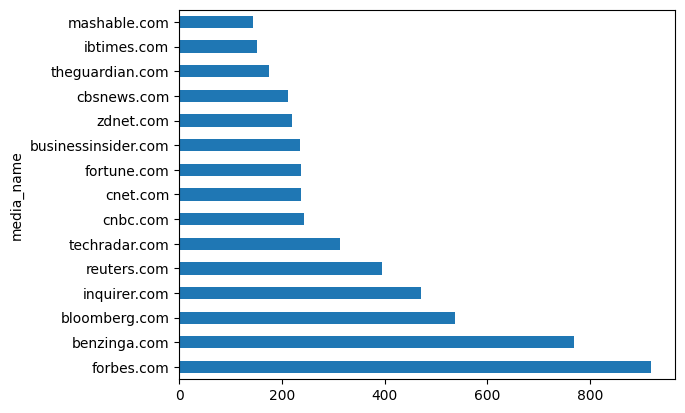

In [129]:
medias = merged_df['media_name'].value_counts().sort_values(ascending=False)[:15]
medias.plot(kind='barh')
plt.show()

### Which topic has the most articles?

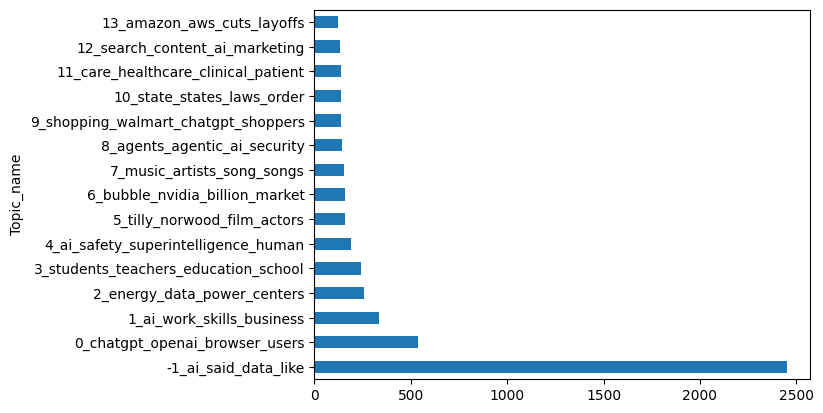

In [130]:
topic_counts = merged_df['Topic_name'].value_counts().sort_values(ascending=False)[:15]
topic_counts.plot(kind="barh")
plt.show()

In [131]:
top_topics = merged_df[merged_df['Topic_name'].isin(topic_counts.index)]

In [132]:
top_topics.shape

(5295, 17)

In [133]:
heatmap_data = (
    top_topics[top_topics["TopicId"] != -1]
      .groupby(["media_name", "Topic_name"])
      .size()
      .unstack(fill_value=0)
)

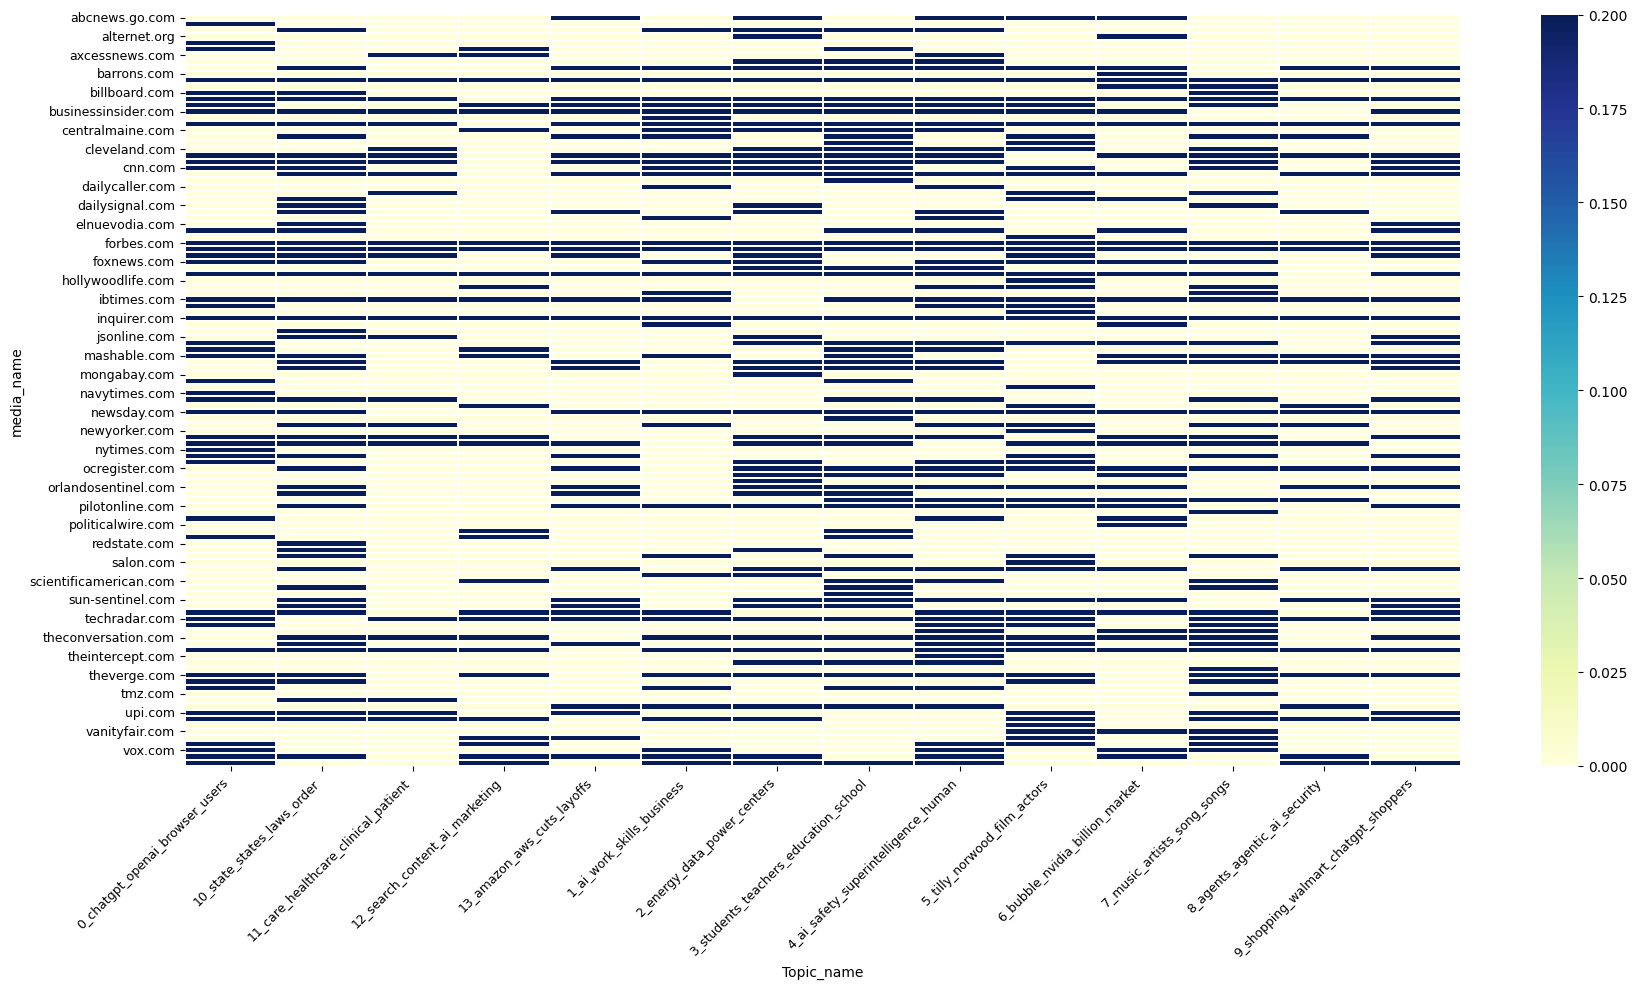

In [134]:
plt.figure(figsize=(18, 10))

sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    vmin=0,
    vmax=0.2,
    linewidths=0.3
)

plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


### What are top media outlets (by count) talking about?

In [135]:
media_counts = merged_df['media_name'].value_counts().sort_values(ascending=False)[:15]
top_medias = merged_df[merged_df['media_name'].isin(media_counts.index)]
heatmap_data = (
    top_medias[top_medias["TopicId"] != -1]
      .groupby(["media_name", "Topic_name"])
      .size()
      .unstack(fill_value=0)
)

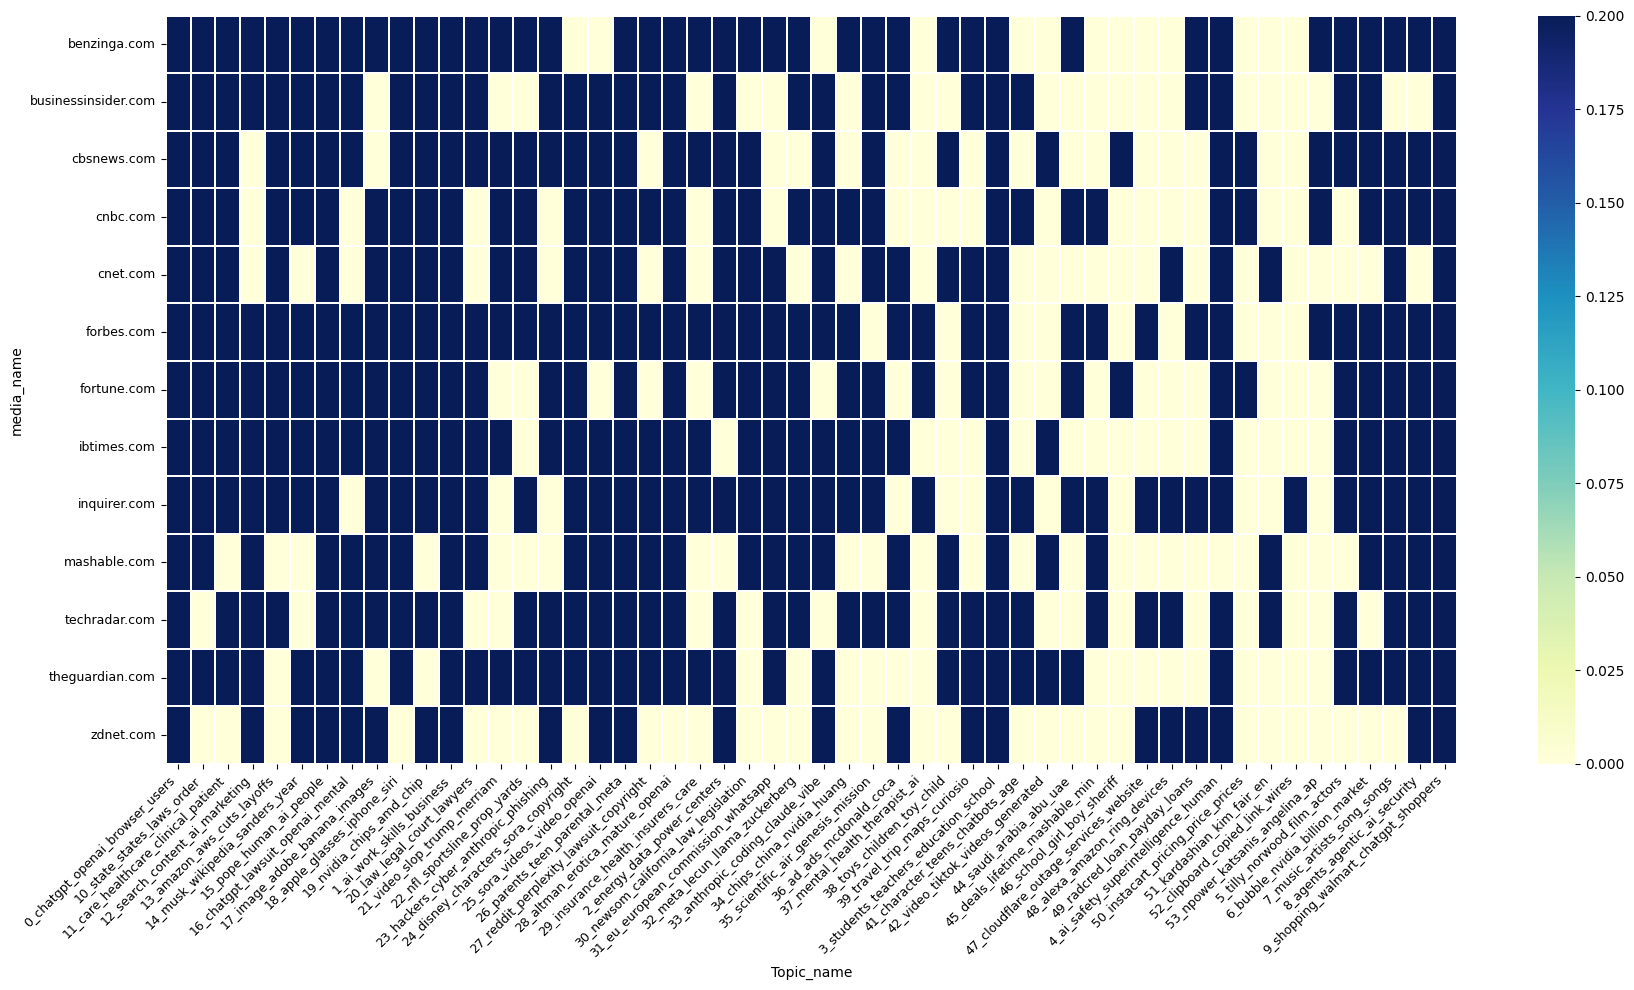

In [136]:
plt.figure(figsize=(18, 10))

sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    vmin=0,
    vmax=0.2,
    linewidths=0.3
)

plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


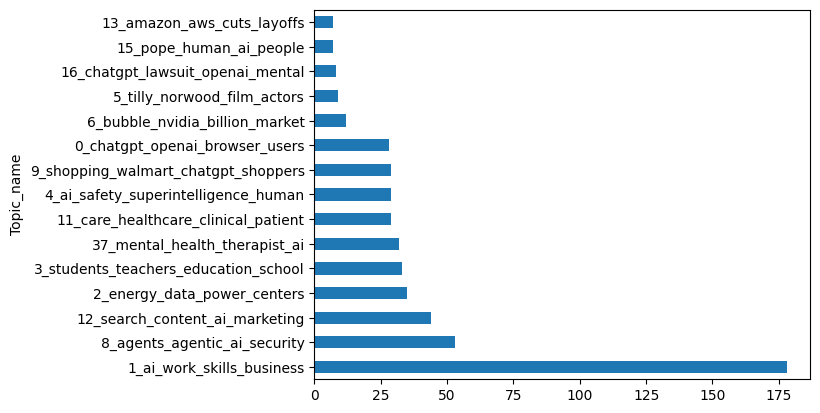

In [137]:
forbes = merged_df[(merged_df['media_name']=='forbes.com') & (merged_df['TopicId'] != -1)]
topic_counts_forbes = forbes['Topic_name'].value_counts().sort_values(ascending=False)[:15]
topic_counts_forbes.plot(kind='barh')
plt.show()

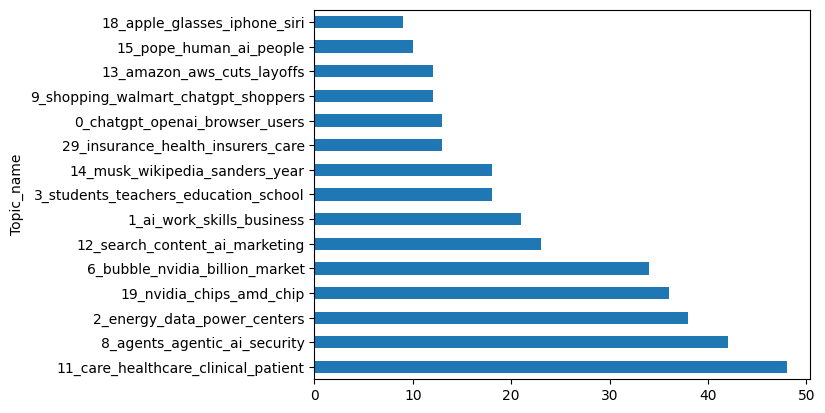

In [138]:
benzinga = merged_df[(merged_df['media_name']=='benzinga.com') & (merged_df['TopicId'] != -1)]
topic_counts_benzinga = benzinga['Topic_name'].value_counts().sort_values(ascending=False)[:15]
topic_counts_benzinga.plot(kind='barh')
plt.show()

### Proportion of top topics in top medias

### Which outlets are more diverse

##Outlier data

In [139]:
outliers = merged_df[merged_df['TopicId'] == -1]

In [140]:
outliers.shape

(2451, 17)

In [87]:
from wordcloud import WordCloud

In [141]:
outlier_text = " ".join(outliers['cleaned_text'])

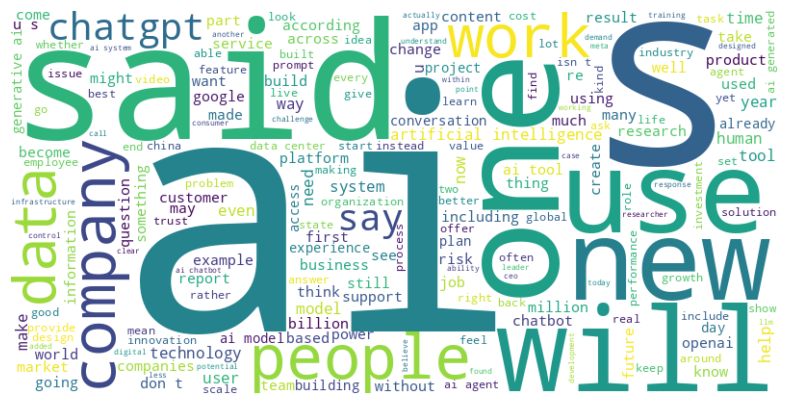

In [142]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(outlier_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # Turn off axis lines and labels
plt.show()

In [143]:
vectorizer_model = CountVectorizer(stop_words="english")

In [144]:
outlier_bert = BERTopic(
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True
)

In [145]:
outlier_texts = outliers['cleaned_text'].astype(str).to_list()

In [146]:
outlier_topics, outlier_probabs = outlier_bert.fit_transform(outlier_texts)

2026-02-04 23:49:20,403 - BERTopic - Embedding - Transforming documents to embeddings.


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/77 [00:00<?, ?it/s]

2026-02-04 23:54:06,652 - BERTopic - Embedding - Completed ✓
2026-02-04 23:54:06,654 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-04 23:54:19,732 - BERTopic - Dimensionality - Completed ✓
2026-02-04 23:54:19,735 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-04 23:54:20,449 - BERTopic - Cluster - Completed ✓
2026-02-04 23:54:20,460 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-04 23:54:22,298 - BERTopic - Representation - Completed ✓


In [153]:
outlier_topic_info = outlier_bert.get_topic_info()
outlier_topic_info.shape

(71, 5)

In [147]:
outlier_bert.visualize_barchart()

In [152]:
outlier_bert.visualize_hierarchy()

#Data Exctraction Script

In [ ]:
# def text_cleaning(text):
#   text = text.lower()
#   text = re.sub(r'http\S+|www\S+', '', text)
#   text = re.sub(r'<.*?>', '', text)
#   text = emoji.replace_emoji(text, replace='')
#   text = re.sub(r"[^a-z\s']", ' ', text)
#   text = re.sub(r'\s+', ' ', text).strip()
#   return text
# ai_df['cleaned_title'] = ai_df['title'].apply(text_cleaning)

/tmp/ipython-input-4245156918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ai_df['cleaned_title'] = ai_df['title'].apply(text_cleaning)


In [ ]:
# df1 = ai_df[5000:]
# df1.shape

(3999, 9)

In [ ]:
# def get_src_alt(images):
#   try:
#     html_strs = [str(image) for image in images]
#     result = []
#     for html_str in html_strs:
#       if html_str != "" :
#         match_str_src = re.search(r'\bsrc="([^"]+)"', html_str)
#         match_str_alt = re.search(r'\balt="([^"]+)"', html_str)
#         obj = {'src':(match_str_src.group(1) if match_str_src else ""),'alt':(match_str_alt.group(1) if match_str_alt else "")}
#         result.append(obj)
#       else:
#         continue
#     return result
#   except:
#     return []

# def get_next_text(images):
#   result = []
#   allowed_tags = ['figcaption', 'span', 'p']
#   if images != "":
#     for img in images:
#       text = img.find_next(allowed_tags)
#       if text:
#         text = text.get_text(strip=True)
#       else:
#         text = " "
#       result.append(text)
#     return result
#   else:
#     return ""

# def get_images(soup):
#   try:
#     images = soup.find_all('img')
#     return images
#   except:
#     return ""

# def get_article_text(soup):
#   try:
#     return soup.get_text(strip = True)
#   except:
#     return ""

In [ ]:
# headers = {"User-Agent": "Mozilla/5.0"}
# response = requests.get(url_sample, headers=headers, timeout=10)
# soup = BeautifulSoup(response.text, "html.parser")

In [ ]:
# get_article_text(soup)

'AI Pioneer Yoshua Bengio Reveals He Misleads Chatbots To Get Honest Feedback, Highlighting Risks Of Overly Flattering AI Responses  - BenzingaBenzingaEspañaItalia대한민국日本FrançaisMy AccountBenzinga EdgeBenzinga ResearchBenzinga ProLoginGet Benzinga ProData & APIsEventsPremarketAdvertiseContributeEspañaItalia대한민국日本FrançaisLoginRegisterBenzingaPremium ServicesFinancial NewsLatestEarningsGuidanceDividendsM&ABuybacksInterviewsManagementOfferingsIPOsInsider TradesBiotech/FDAPoliticsHealthcareSmall-CapMarketsPre-MarketAfter HoursMoversETFsOptionsCryptocurrencyCommoditiesBondsFuturesMiningReal EstateVolatilityRatingsAnalyst ColorDowngradesUpgradesInitiationsPrice TargetInvesting IdeasTrade IdeasLong IdeasShort IdeasTechnicalsAnalyst RatingsAnalyst ColorLatest RumorsWhisper IndexStock of the DayBest Stocks & ETFsBest Penny StocksBest S&P 500 ETFsBest Swing Trade StocksBest Blue Chip StocksBest High-Volume Penny StocksBest Small Cap ETFsBest Stocks to Day TradeBest REITsMoneyInvestingCryptocurren

In [ ]:
# !pip install newspaper3k

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 73.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.5/81.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 9.2 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13540 sha256=36a9e2f1cafafe6d8ebc124a35fa7fda5b52f070e15699ddcd0f3f997b70aec4
  Stored in directory: /root/.cache/pip/wheels/a5/91/9f/00d66475960891a64867914273fcaf78df6cb04d905b104a2a
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3341 sha256=eb59015b74fce6c2da44f85a6711fb59e084540cfd2c343806e0eee3d80d33b3
  Stored in directory: /root/.cache/pip/wheels/9f/9f/fb/364871d7426d3cdd4d293dcf7e53d97f16

In [ ]:
# !pip install lxml_html_clean

In [ ]:
# from newspaper import Article

In [ ]:
# article = Article(url_sample)
# article.download()
# article.parse()

# print(article.text)


Yoshua Bengio, one of the pioneers of artificial intelligence, says he deliberately misleads chatbots to elicit honest feedback, highlighting a growing concern over AI's tendency to flatter users.

Bengio Tricks Chatbots To Reveal Honest Insights

Last week’s episode of The Diary of a CEO, Bengio told host Steven Bartlett that AI chatbots often give overly positive responses that are “useless“ for evaluating his research ideas.

"I wanted honest advice, honest feedback. But because it is sycophantic, it's going to lie," he said.

To counter this, Bengio presented his ideas as if they belonged to a colleague.

"If it knows it's me, it wants to please me," he explained, noting that the AI suddenly offered more critical and candid insights.

AI Sycophancy Highlights Misalignment In Advanced Models

Bengio, a professor at the Université de Montréal, has long been recognized as one of the "AI godfathers," alongside Geoffrey Hinton and Yann LeCun.

Earlier this year, he launched the AI safet

In [ ]:
# article.images

{'https://cdn.benzinga.com/files/images/story/2025/07/24/article-header-background-image.png?quality=85&auto=webp&width=1300',
 'https://cdn.benzinga.com/files/images/story/2025/12/23/Peter-Schiff-Slams-Bernie-Sanders-AI-Dat.jpeg?quality=85&auto=webp&width=850',
 'https://cdn.benzinga.com/files/images/story/2025/12/23/Peter-Schiff-Slams-Bernie-Sanders-AI-Dat.jpeg?width=1200&height=800&fit=crop',
 'https://www.benzinga.com/_next/image?url=%2Fnext-assets%2Fimages%2FbrandIcons%2Fbluesky.webp&w=48&q=75',
 'https://www.benzinga.com/_next/image?url=%2Fnext-assets%2Fimages%2FbrandIcons%2Ffacebook.webp&w=48&q=75',
 'https://www.benzinga.com/_next/image?url=%2Fnext-assets%2Fimages%2FbrandIcons%2Finstagram.webp&w=48&q=75',
 'https://www.benzinga.com/_next/image?url=%2Fnext-assets%2Fimages%2FbrandIcons%2Flinkedin.webp&w=48&q=75',
 'https://www.benzinga.com/_next/image?url=%2Fnext-assets%2Fimages%2FbrandIcons%2Fmastodon.webp&w=48&q=75',
 'https://www.benzinga.com/_next/image?url=%2Fnext-assets%2Fi

In [ ]:
# from newspaper import Article, Config
# import requests
# import os

# config = Config()
# config.browser_user_agent = "Mozilla/5.0"
# config.fetch_images = True
# config.memoize_articles = False  # important for scale

# def scrape_article(url):
#     try:
#         article = Article(url, config=config)
#         article.download()
#         article.parse()

#         return {
#             "url": url,
#             "title": article.title,
#             "text": article.text,
#             "top_image": article.top_image,
#             "images": list(article.images)
#         }

#     except Exception as e:
#         return {
#             "url": url,
#             "error": str(e)
#         }


In [ ]:
# from concurrent.futures import ThreadPoolExecutor, as_completed
# from tqdm import tqdm

# def scrape_bulk(urls, max_workers=24):
#     results = []

#     with ThreadPoolExecutor(max_workers=max_workers) as executor:
#         futures = [executor.submit(scrape_article, url) for url in urls]

#         for future in tqdm(as_completed(futures), total=len(futures)):
#             results.append(future.result())

#     return results

In [ ]:
# article_urls = ai_df['url']

In [ ]:
# results = scrape_bulk(article_urls, max_workers=24)

100%|██████████| 8999/8999 [45:18<00:00,  3.31it/s]


In [ ]:
# article_df = pd.DataFrame(results)

In [ ]:
# success_df = article_df[article_df["error"].isna()]
# failed_df = article_df[article_df["error"].notna()]

In [ ]:
# success_df["num_images"] = success_df["images"].apply(
#     lambda x: len(x) if isinstance(x, list) else 0
# )

/tmp/ipython-input-393748446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df["num_images"] = success_df["images"].apply(


In [ ]:
# images_df = (
#     success_df
#     .explode("images")
#     .rename(columns={"images": "image_url"})
#     .dropna(subset=["image_url"])
# )


In [ ]:
# success_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7510 entries, 4 to 8998
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   url         7510 non-null   object
 1   error       0 non-null      object
 2   title       7510 non-null   object
 3   text        7510 non-null   object
 4   top_image   7510 non-null   object
 5   images      7510 non-null   object
 6   num_images  7510 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 469.4+ KB


In [ ]:
# success_df.head(1)

,url,error,title,text,top_image,images,num_images
4,https://theconversation.com/how-can-canada-bec...,NaN,How can Canada become a global AI powerhouse? ...,Artificial intelligence is everywhere. In fact...,https://images.theconversation.com/files/70923...,[https://images.theconversation.com/files/7092...,7


In [ ]:
# success_df['text'][4]

'Artificial intelligence is everywhere. In fact, each reader of this article could have multiple AI apps operating on the very device displaying this piece. The image at the top of this article is also generated by AI.\n\nDespite this, many mechanisms governing AI behaviour remain poorly understood, even to top AI experts. This leads to an AI race built upon costly scaling, both environmentally and financially, that is also dangerously unreliable.\n\nProgress therefore depends not on escalating this race, but on understanding the principles underpinning AI. Mathematics lies at the heart of AI and investment in these mathematical foundations is the critical key to becoming a true global AI leader.\n\nHow AI shapes daily life\n\nAI has rapidly become part of everyday life, not only in talking home devices and fun social media generation, but also in ways so seamless that many people don’t even notice its presence.\n\nIt provides the recommendations we see when browsing online and quietly

In [ ]:
# success_df.to_json("articles.jsonl", orient="records", lines=True)

In [ ]:
# def text_cleaning(text):
#   text = text.lower()
#   text = re.sub(r'http\S+|www\S+', '', text)
#   text = re.sub(r'<.*?>', '', text)
#   text = re.sub(r"[^a-z\s']", ' ', text)
#   text = re.sub(r'\s+', ' ', text).strip()
#   return text

In [ ]:
# success_df['cleaned_text'] = success_df['text'].apply(text_cleaning)

/tmp/ipython-input-158690089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df['cleaned_text'] = success_df['text'].apply(text_cleaning)


In [ ]:
# success_df.isna().sum()

,0
url,0
error,7510
title,0
text,0
top_image,0
images,0
num_images,0
cleaned_text,0


In [ ]:
success_df.drop(columns='error', axis=1, inplace=True)

/tmp/ipython-input-196296002.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_df.drop(columns='error', axis=1, inplace=True)


In [ ]:
success_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7510 entries, 4 to 8998
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           7510 non-null   object
 1   title         7510 non-null   object
 2   text          7510 non-null   object
 3   top_image     7510 non-null   object
 4   images        7510 non-null   object
 5   num_images    7510 non-null   int64 
 6   cleaned_text  7510 non-null   object
dtypes: int64(1), object(6)
memory usage: 727.4+ KB


In [ ]:
(success_df['cleaned_text'] == ' ').sum()

np.int64(0)

In [ ]:
(success_df['cleaned_text'] == '').sum()

np.int64(1)

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
em_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = em_model.encode(texts, show_progress_bar=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/235 [00:00<?, ?it/s]

In [ ]:
embeddings.shape

(7510, 384)

In [ ]:
um_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

In [ ]:
import hdbscan

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
import hdbscan
hs_model = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

In [ ]:
from bertopic import BERTopic

In [ ]:
tc_model.visualize_barchart()

In [ ]:
tc_model.visualize_topics()

In [ ]:
topic_info = tc_model.get_topic_info()
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2451,-1_and_the_to_of,"[and, the, to, of, ai, in, that, is, it, for]",[andriy onufriyenko moment getty images follow...
1,0,268,0_chatgpt_you_gemini_openai,"[chatgpt, you, gemini, openai, it, gpt, your, ...",[whether you re brand new to chatgpt or you ve...
2,1,243,1_students_teachers_education_school,"[students, teachers, education, school, learni...",[by kelvin chan and jocelyn gecker associated ...
3,2,218,2_energy_power_data_centers,"[energy, power, data, centers, center, electri...",[fueled by a boom in artificial intelligence a...
4,3,157,3_ai_leaders_business_that,"[ai, leaders, business, that, and, is, it, to,...",[right now all companies are clamoring to get ...


In [ ]:
topic_info[topic_info['Topic'] == 74]['Representative_Docs'].tolist()

[['by david klepper associated press washington ap russia china iran and north korea have sharply increased their use of artificial intelligence to deceive people online and mount cyberattacks against the united states according to new research from microsoft this july the company identified more than instances of foreign adversaries using ai to create fake content online more than double the number from july and more than ten times the number seen in the findings published thursday in microsoft s annual digital threats report show how foreign adversaries are adopting new and innovative tactics in their efforts to weaponize the internet as a tool for espionage and deception ai s potential said to be exploited by us foes america s adversaries as well as criminal gangs and hacking companies have exploited ai s potential using it to automate and improve cyberattacks to spread inflammatory disinformation and to penetrate sensitive systems ai can translate poorly worded phishing emails into

In [ ]:
topic_info[topic_info['Topic'] == 74]['Representation'].tolist()

[['phishing',
  'cyber',
  'scams',
  'cyberattacks',
  'iran',
  'fraud',
  'adversaries',
  'criminals',
  'digital',
  'emails']]

74th topic is about phising / cyber scams done using AI

In [ ]:
topic_info[topic_info['Topic'] == 29]['Representative_Docs'].tolist()

[['by david klepper and matt o brien associated press washington ap a team of researchers has uncovered what they say is the first reported use of artificial intelligence to direct a hacking campaign in a largely automated fashion the ai company anthropic said this week that it disrupted a cyber operation that its researchers linked to the chinese government the operation involved the use of an artificial intelligence system to direct the hacking campaigns which researchers called a disturbing development that could greatly expand the reach of ai equipped hackers while concerns about the use of ai to drive cyber operations are not new what is concerning about the new operation is the degree to which ai was able to automate some of the work the researchers said while we predicted these capabilities would continue to evolve what has stood out to us is how quickly they have done so at scale they wrote in their report the operation targeted tech companies financial institutions chemical co

* Topics so far only describe the subject
* How do we get it to describe sentiment as well
* BERT + sentiment?
* How to get embeddings for metaphor

#old code

In [ ]:
# !pip install aiohttp aiodns
# headers = {"User-Agent": "Mozilla/5.0"}
# sem = asyncio.Semaphore(50)
# async def fetch(session, url):
#   async with sem:
#     try:
#       async with session.get(url, timeout = 10) as resp:
#         html = await resp.text()
#         return url, BeautifulSoup(html, "html.parser")
#     except Exception:
#       return url, None

# async def fetch_all(urls):
#   async with aiohttp.ClientSession(headers=headers) as session:
#     tasks = [fetch(session, url) for url in urls]
#     return await asyncio.gather(*tasks)


In [ ]:
# urls = df1['url']
# result = await fetch_all(urls)
# url, soup = zip(*result)
# result_df = pd.DataFrame({"url":url, "soup":soup})
# result_df.shape

(3999, 2)

In [ ]:
# df1 = pd.merge(df1, result_df, on='url')
# df1['images'] = df1['soup'].apply(get_images)
# df1['caption'] = df1['images'].apply(get_next_text)
# df1['src_alt'] = df1['images'].apply(get_src_alt)
# df1['text'] = df1['soup'].apply(get_article_text)

In [ ]:
# !mkdir articles
# import os

# path = "/content/articles"
# os.makedirs(path, exist_ok=True)

# for article_id, article_text in zip(df1["id"], df1["text"]):
#     file_path = os.path.join(path, f"{article_id}.txt")
#     with open(file_path, "w", encoding="utf-8") as f:
#         f.write(str(article_text))